In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
import shap

shap.initjs()


In [2]:
# Change to your actual path if needed
csv_path = "./Data/arr_dep_demo.csv"
lateness_demo = pd.read_csv(csv_path)

print("Shape:", lateness_demo.shape)
display(lateness_demo.head())

Shape: (3223, 15)


,route_id,stop_id,lateness,scheduled_headway,time_point_order,earliness,actual,scheduled,point_type,standard_type,direction,pct_white,pct_black,pct_asian,pct_hispanic
0,01,2,3.918361,11.326798,2.000985,-25.974048,1900-01-01 05:02:07+00:00,1900-01-01 04:38:00+00:00,Midpoint,Schedule,outbound,0.057253,0.314571,0.038598,0.580251
1,01,12,3.145690,NaN,NaN,NaN,1900-01-01 10:05:59+00:00,1900-01-01 07:22:00+00:00,Pullback,NaN,inbound,NaN,NaN,NaN,NaN
2,01,59,5.853761,11.444941,7.004100,-50.782828,1900-01-01 05:28:26+00:00,1900-01-01 05:28:00+00:00,Midpoint,Schedule,inbound,0.545237,0.172964,0.145556,0.081426
3,01,62,6.114950,11.439361,8.004010,-43.000000,1900-01-01 05:33:38+00:00,1900-01-01 05:32:00+00:00,Midpoint,Schedule,inbound,0.057253,0.314571,0.038598,0.580251
4,01,64,3.603530,11.412198,4.941872,171.006751,1900-01-01 05:34:00+00:00,1900-01-01 05:33:00+00:00,Endpoint,Schedule,inbound,0.358454,0.154289,0.285284,0.138942


#### feature engineering

In [3]:
df = lateness_demo.copy()

# ---- 1.1 Drop rows with missing *critical* values ----
critical_cols = [
    "lateness",
    "scheduled_headway",
    "pct_white",
    "pct_black",
    "pct_asian",
    "pct_hispanic",
]
df = df.dropna(subset=critical_cols).copy()

# ---- 1.2 Compute stop-level minority share ----
df["pct_minority_stop"] = (
    df["pct_black"].fillna(0)
    + df["pct_asian"].fillna(0)
    + df["pct_hispanic"].fillna(0)
)

# ---- 1.3 Time-of-day features from scheduled time ----
df["scheduled"] = pd.to_datetime(df["scheduled"], utc=True, errors="coerce")

# numeric hour of day: 0–24, with minutes as fraction
df["scheduled_hour"] = df["scheduled"].dt.hour + df["scheduled"].dt.minute / 60.0

# peak indicator (you can tweak ranges if you want)
df["is_peak"] = (
    ((df["scheduled_hour"] >= 7) & (df["scheduled_hour"] < 10))
    | ((df["scheduled_hour"] >= 16) & (df["scheduled_hour"] < 19))
).astype(int)

# ---- 1.4 Route-level features: length, mean lateness, minority exposure ----
route_group = (
    df.groupby("route_id")
    .agg(
        route_length=("stop_id", "nunique"),
        route_pct_white_avg=("pct_white", "mean"),
        route_pct_black_avg=("pct_black", "mean"),
        route_pct_asian_avg=("pct_asian", "mean"),
        route_pct_hispanic_avg=("pct_hispanic", "mean"),
    )
    .reset_index()
)

route_group["pct_minority_route"] = (
    route_group["route_pct_black_avg"].fillna(0)
    + route_group["route_pct_asian_avg"].fillna(0)
    + route_group["route_pct_hispanic_avg"].fillna(0)
)

# merge back
df = df.merge(route_group[["route_id", "route_length", "pct_minority_route"]],
              on="route_id", how="left")

# ---- 1.5 Clean / transform some numeric features ----
# log headway to reduce skew (optional)
df["scheduled_headway_log"] = np.log1p(df["scheduled_headway"])

# earliness: keep as-is but coerce numeric
# df["earliness"] = pd.to_numeric(df["earliness"], errors="coerce")
df["time_point_order"] = pd.to_numeric(df["time_point_order"], errors="coerce")

# you can fill small NaNs with median for non-critical engineered features
for col in ["time_point_order", "scheduled_hour"]:
    df[col] = df[col].fillna(df[col].median())


In [4]:
# ============================================
# 2. CATEGORICAL ENCODING
# ============================================

# Categorical columns: use one-hot encoding
cat_cols = ["point_type", "standard_type", "direction"]

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Columns we DO NOT want as features
drop_cols = [
    "lateness",          # target
    "route_id", "stop_id",
    "actual", "scheduled",  # raw timestamps
    "earliness"
]

feature_cols = [c for c in df_encoded.columns if c not in drop_cols]

X = df_encoded[feature_cols]
y = df_encoded["lateness"]

print("Feature matrix shape:", X.shape)
print("Number of features:", len(feature_cols))


Feature matrix shape: (1020, 15)
Number of features: 15


In [5]:
print("\nFEATURE NAMES")
for i, f in enumerate(feature_cols):
    print(f"{i+1}. {f}")



FEATURE NAMES
1. scheduled_headway
2. time_point_order
3. pct_white
4. pct_black
5. pct_asian
6. pct_hispanic
7. pct_minority_stop
8. scheduled_hour
9. is_peak
10. route_length
11. pct_minority_route
12. scheduled_headway_log
13. point_type_Midpoint
14. point_type_Startpoint
15. direction_outbound


In [6]:
# ============================================
# 3. TRAIN / TEST SPLIT
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (816, 15) Test: (204, 15)


In [7]:
# ============================================
# 4. XGBOOST REGRESSOR
# ============================================
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=600,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")
print(f"Train R^2:  {r2_train:.3f}, Test R^2:  {r2_test:.3f}")


Train RMSE: 0.435, Test RMSE: 1.120
Train R^2:  0.944, Test R^2:  0.479


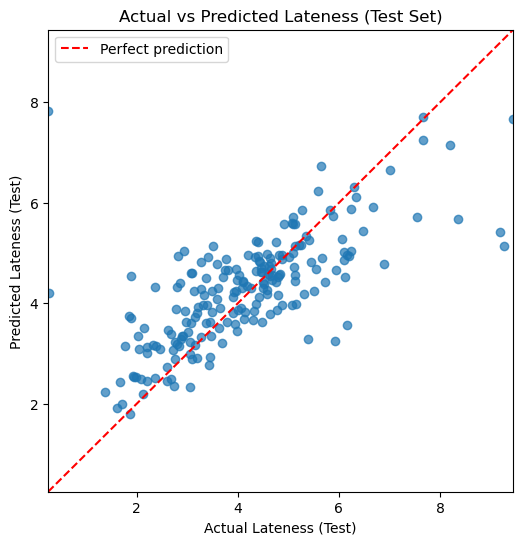

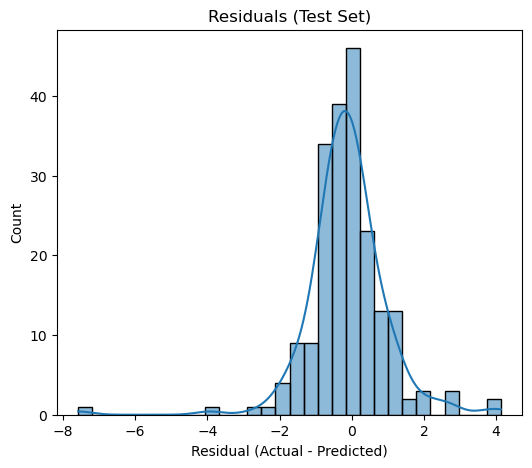

In [8]:
# ============================================
# 5. BASIC DIAGNOSTIC PLOTS
# ============================================

# 5.1 Actual vs Predicted (Test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, "r--", label="Perfect prediction")
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Actual Lateness (Test)")
plt.ylabel("Predicted Lateness (Test)")
plt.title("Actual vs Predicted Lateness (Test Set)")
plt.legend()
plt.show()

# 5.2 Residuals
residuals = y_test - y_pred_test
plt.figure(figsize=(6,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals (Test Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()


## SHAP 

SHAP matrix shape: (816, 15)


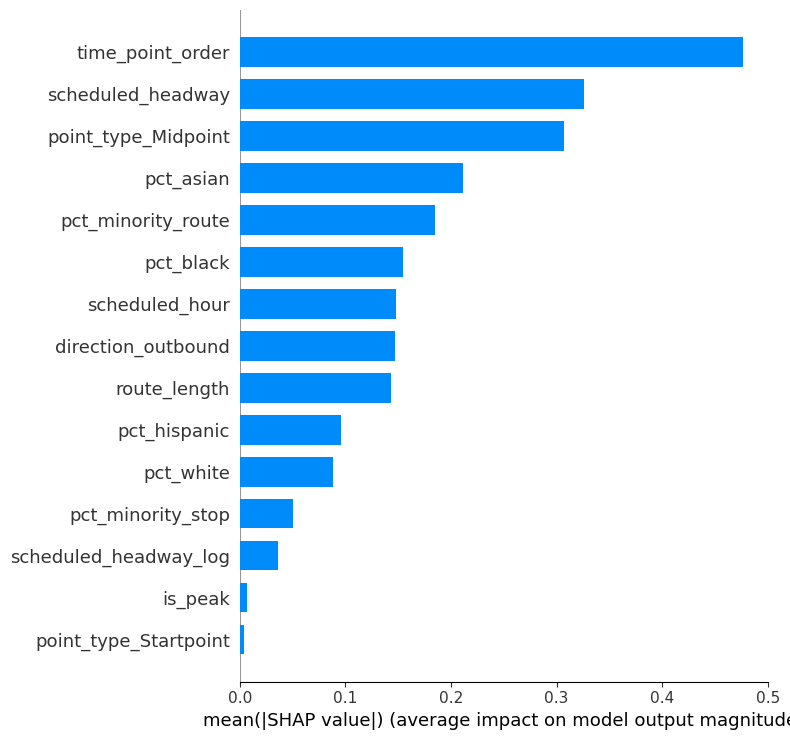

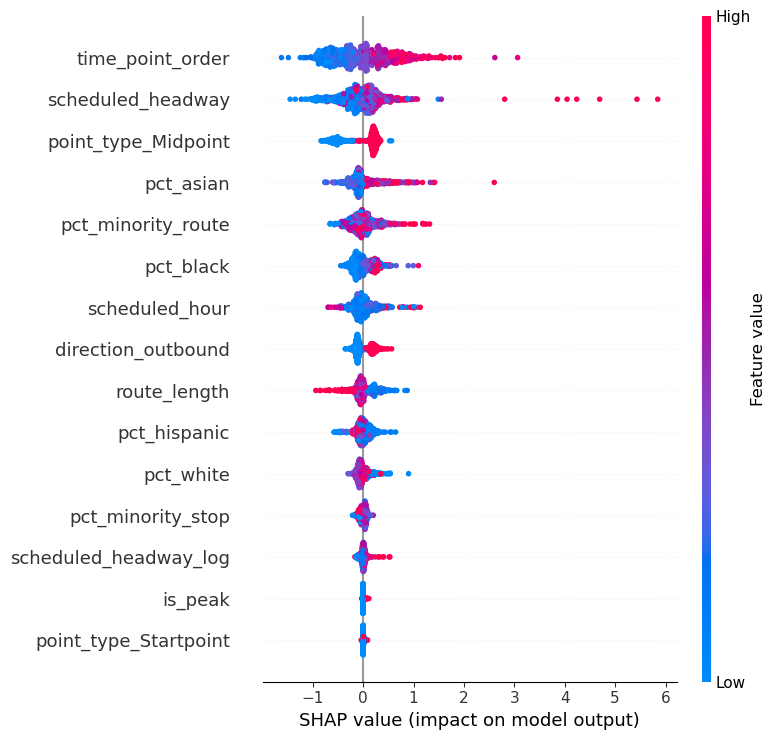

In [9]:
# ============================================
# 6. SHAP GLOBAL EXPLANATIONS
# ============================================
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

print("SHAP matrix shape:", shap_values.shape)

# ---- 6.1 Global Importance (Bar Plot) ----
shap.summary_plot(
    shap_values,
    X_train,
    feature_names=X_train.columns,
    plot_type="bar",
    max_display=20,
    show=True
)

# ---- 6.2 Beeswarm Plot (Full Distribution) ----
shap.summary_plot(
    shap_values,
    X_train,
    feature_names=X_train.columns,
    max_display=20,
    show=True
)


In [28]:
# # ============================================
# # 1. SHAP INTERACTION VALUES (sampled)
# # ============================================
# import numpy as np
# import shap
# import matplotlib.pyplot as plt

# # To keep it fast, take a sample from the test set
# sample_size = min(400, X_test.shape[0])
# X_test_sample = X_test.sample(sample_size, random_state=42)

# shap_inter = explainer.shap_interaction_values(X_test_sample)

# # Global interaction strength plot
# shap.summary_plot(
#     shap_inter,
#     X_test_sample,
#     feature_names=X_test_sample.columns,
#     max_display=15
# )


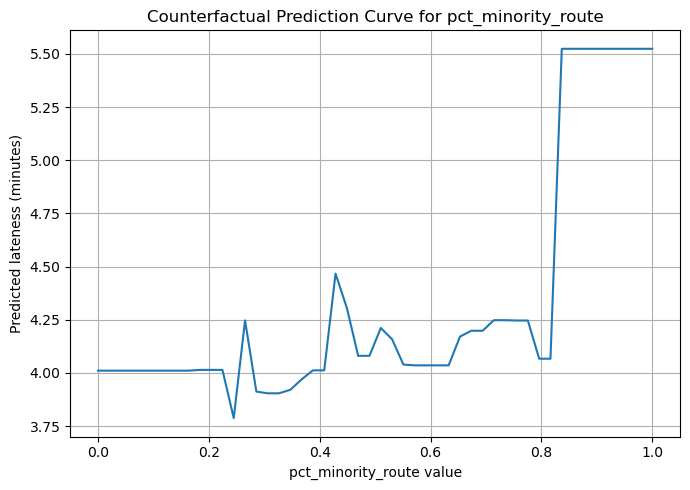

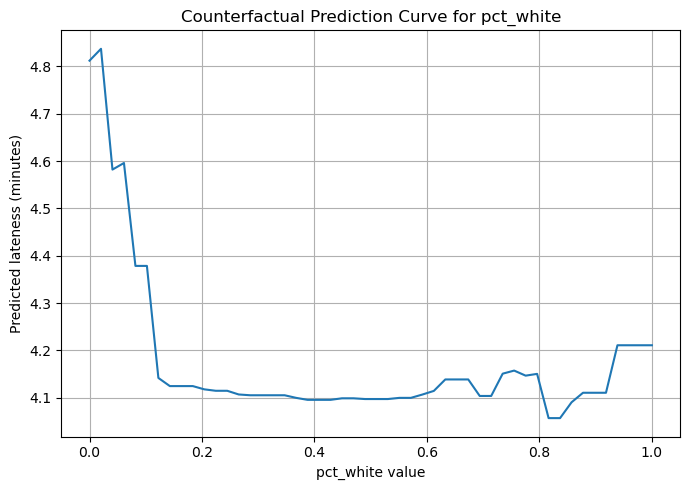

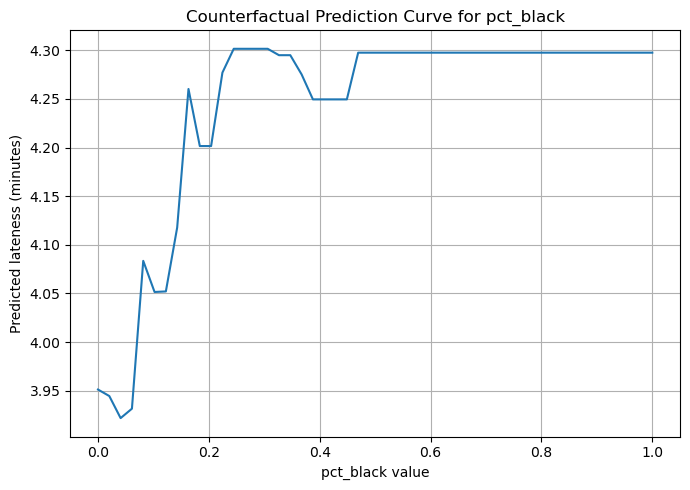

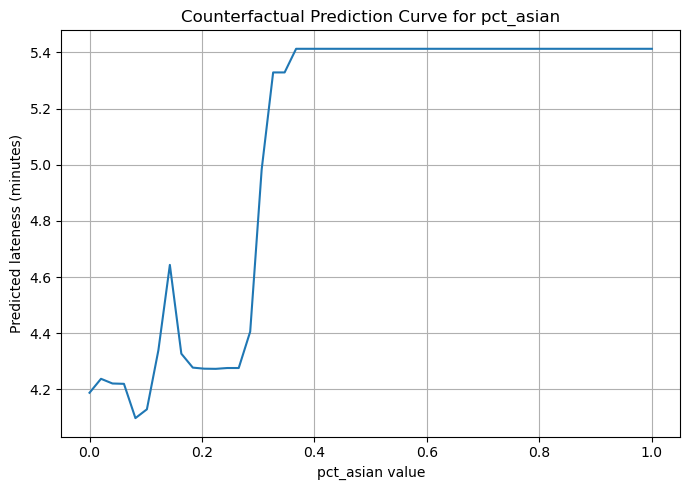

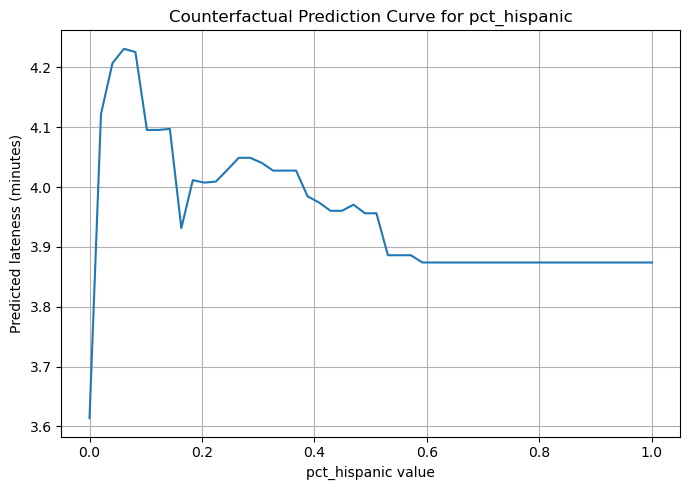

In [33]:
def shap_counterfactual_curve(feature, num_points=50):
    # Create a "neutral" baseline passenger/stop profile
    base = X_train.median().to_frame().T  
    
    # Sweep feature values from 0 → 1
    values = np.linspace(0, 1, num_points)

    preds = []
    for v in values:
        temp = base.copy()
        temp[feature] = v
        preds.append(xgb_model.predict(temp)[0])

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(values, preds, marker=None)
    plt.xlabel(f"{feature} value")
    plt.ylabel("Predicted lateness (minutes)")
    plt.title(f"Counterfactual Prediction Curve for {feature}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ===== Run for all demographic features =====

features_to_test = [
    "pct_minority_route",
    "pct_white",
    "pct_black",
    "pct_asian",
    "pct_hispanic"
]

for f in features_to_test:
    shap_counterfactual_curve(f)


### Counterfactual Fairness Test

“How much does predicted lateness change if minority share changes, keeping everything else fixed?”

#### for pct_minority_route


Example index: 924
  Original pct_minority_route: 0.42
  Original prediction: 3.862 minutes
  Counterfactual predictions (varying minority share):


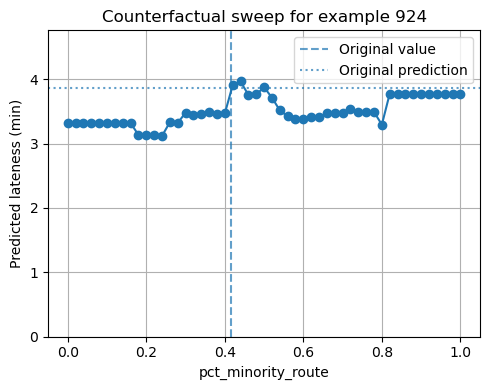


Example index: 981
  Original pct_minority_route: 0.58
  Original prediction: 2.939 minutes
  Counterfactual predictions (varying minority share):


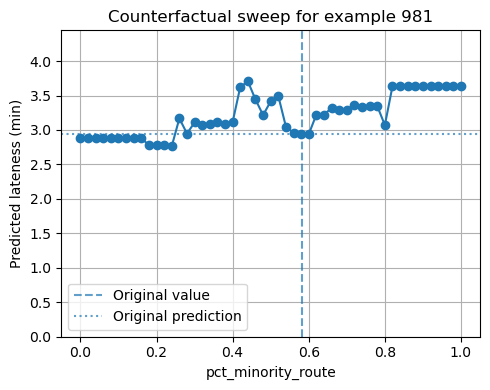


Example index: 809
  Original pct_minority_route: 0.47
  Original prediction: 5.046 minutes
  Counterfactual predictions (varying minority share):


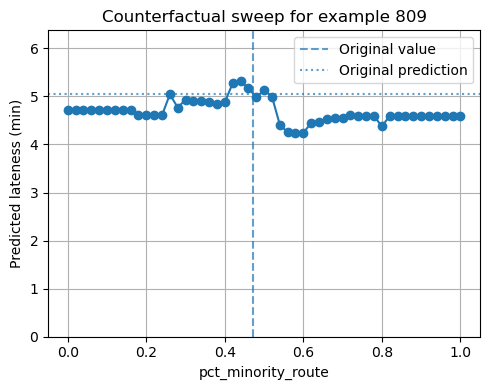


Example index: 589
  Original pct_minority_route: 0.46
  Original prediction: 3.591 minutes
  Counterfactual predictions (varying minority share):


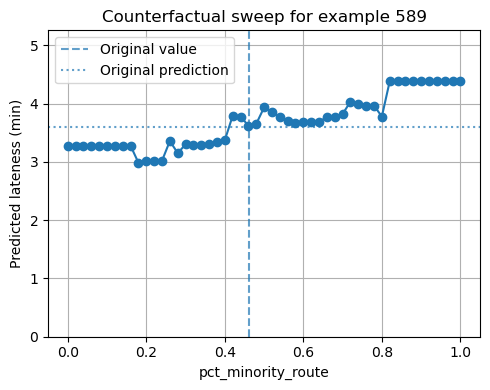


Example index: 296
  Original pct_minority_route: 0.54
  Original prediction: 3.020 minutes
  Counterfactual predictions (varying minority share):


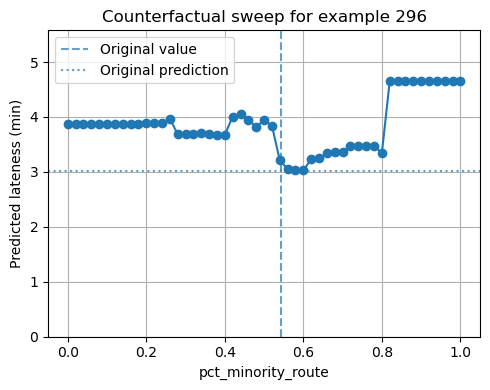

In [22]:
# Pick a few representative rows from test set
feature_to_vary = "pct_minority_route"  # could also test pct_minority_stop
# values_grid = [0.0, 0.25, 0.5, 0.75, 1.0]
values_grid = np.linspace(0, 1, 51)  # 41 values: 0.00, 0.025, ..., 1.00


examples_idx = X_test.sample(5, random_state=0).index

for idx in examples_idx:
    row = X_test.loc[idx]
    base_pred = xgb_model.predict(pd.DataFrame([row]))[0]
    cf_preds = counterfactual_sweep(row, feature_to_vary, values_grid)

    # ==== PRINT RESULTS ====
    print(f"\nExample index: {idx}")
    print(f"  Original {feature_to_vary}: {row[feature_to_vary]:.2f}")
    print(f"  Original prediction: {base_pred:.3f} minutes")
    print("  Counterfactual predictions (varying minority share):")
    # for v, p in cf_preds.items():
    #     # print(f"    {feature_to_vary}={v:4.2f} → pred lateness={p:.3f} min")

    # ==== PLOT RESULTS ====
    vals = np.array(values_grid)
    preds_arr = np.array([cf_preds[v] for v in values_grid])

    plt.figure(figsize=(5, 4))
    plt.plot(vals, preds_arr, marker="o")
    # Mark the original point
    plt.axvline(row[feature_to_vary], linestyle="--", alpha=0.7, label="Original value")
    plt.axhline(base_pred, linestyle=":", alpha=0.7, label="Original prediction")

    plt.xlabel(feature_to_vary)
    plt.ylabel("Predicted lateness (min)")
    plt.title(f"Counterfactual sweep for example {idx}")
    plt.ylim(0, max(preds_arr.max(), base_pred) * 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### for pct_white


Example index: 924
  Original pct_white: 0.44
  Original prediction: 3.862 minutes
  Counterfactual predictions (varying pct_white share):


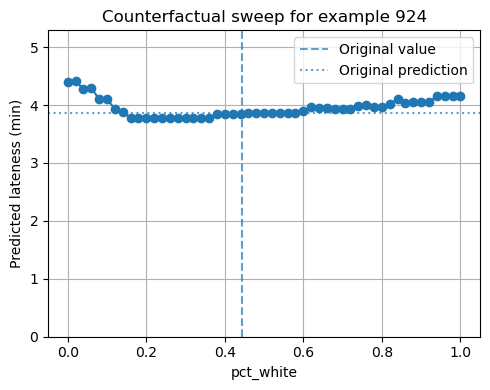


Example index: 981
  Original pct_white: 0.24
  Original prediction: 2.939 minutes
  Counterfactual predictions (varying pct_white share):


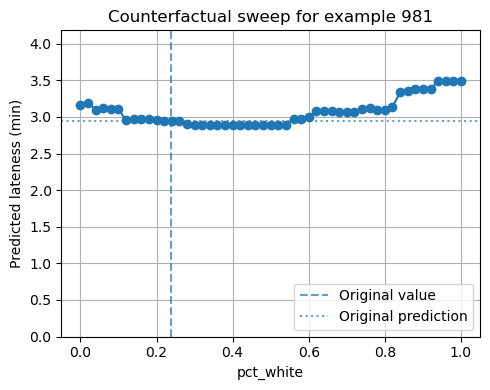


Example index: 809
  Original pct_white: 0.56
  Original prediction: 5.046 minutes
  Counterfactual predictions (varying pct_white share):


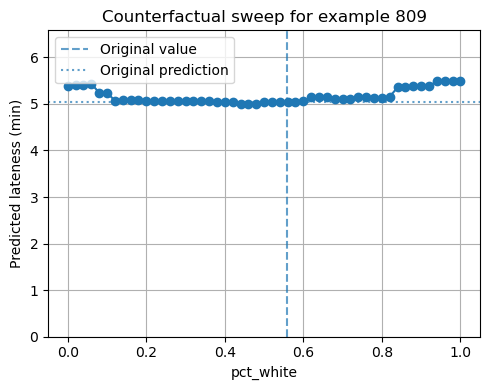


Example index: 589
  Original pct_white: 0.58
  Original prediction: 3.591 minutes
  Counterfactual predictions (varying pct_white share):


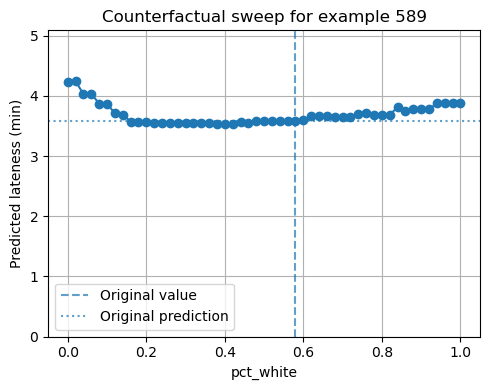


Example index: 296
  Original pct_white: 0.48
  Original prediction: 3.020 minutes
  Counterfactual predictions (varying pct_white share):


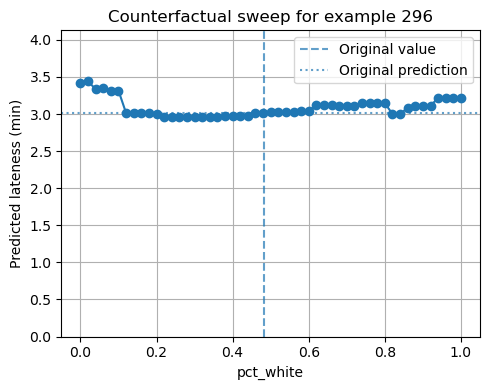

In [23]:
# Pick a few representative rows from test set
feature_to_vary = "pct_white"  # could also test pct_minority_stop
# values_grid = [0.0, 0.25, 0.5, 0.75, 1.0]
values_grid = np.linspace(0, 1, 51)  # 41 values: 0.00, 0.025, ..., 1.00


examples_idx = X_test.sample(5, random_state=0).index

for idx in examples_idx:
    row = X_test.loc[idx]
    base_pred = xgb_model.predict(pd.DataFrame([row]))[0]
    cf_preds = counterfactual_sweep(row, feature_to_vary, values_grid)

    # ==== PRINT RESULTS ====
    print(f"\nExample index: {idx}")
    print(f"  Original {feature_to_vary}: {row[feature_to_vary]:.2f}")
    print(f"  Original prediction: {base_pred:.3f} minutes")
    print("  Counterfactual predictions (varying pct_white share):")
    # for v, p in cf_preds.items():
    #     # print(f"    {feature_to_vary}={v:4.2f} → pred lateness={p:.3f} min")

    # ==== PLOT RESULTS ====
    vals = np.array(values_grid)
    preds_arr = np.array([cf_preds[v] for v in values_grid])

    plt.figure(figsize=(5, 4))
    plt.plot(vals, preds_arr, marker="o")
    # Mark the original point
    plt.axvline(row[feature_to_vary], linestyle="--", alpha=0.7, label="Original value")
    plt.axhline(base_pred, linestyle=":", alpha=0.7, label="Original prediction")

    plt.xlabel(feature_to_vary)
    plt.ylabel("Predicted lateness (min)")
    plt.title(f"Counterfactual sweep for example {idx}")
    plt.ylim(0, max(preds_arr.max(), base_pred) * 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### for pct_black


Example index: 924
  Original pct_black: 0.08
  Original prediction: 3.862 minutes
  Counterfactual predictions (varying pct_black share):


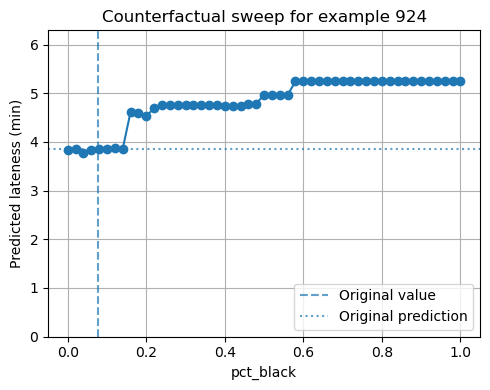


Example index: 981
  Original pct_black: 0.19
  Original prediction: 2.939 minutes
  Counterfactual predictions (varying pct_black share):


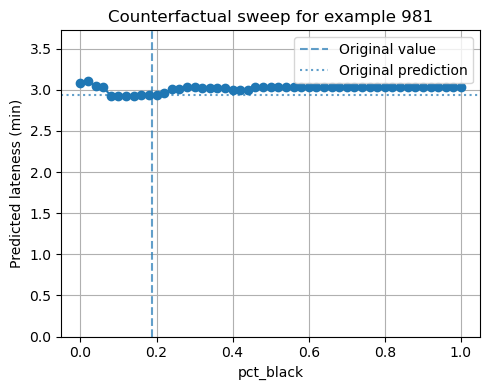


Example index: 809
  Original pct_black: 0.14
  Original prediction: 5.046 minutes
  Counterfactual predictions (varying pct_black share):


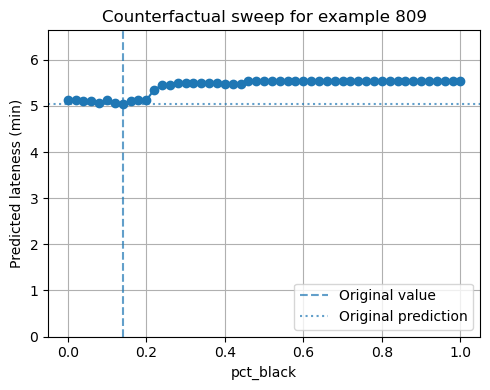


Example index: 589
  Original pct_black: 0.10
  Original prediction: 3.591 minutes
  Counterfactual predictions (varying pct_black share):


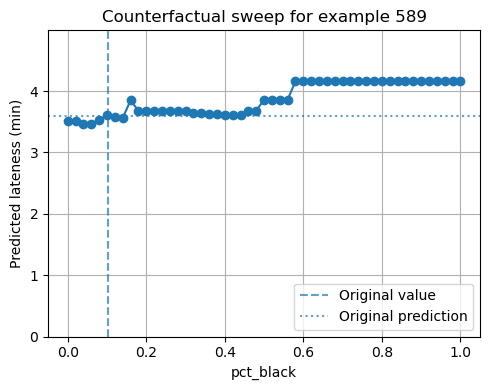


Example index: 296
  Original pct_black: 0.20
  Original prediction: 3.020 minutes
  Counterfactual predictions (varying pct_black share):


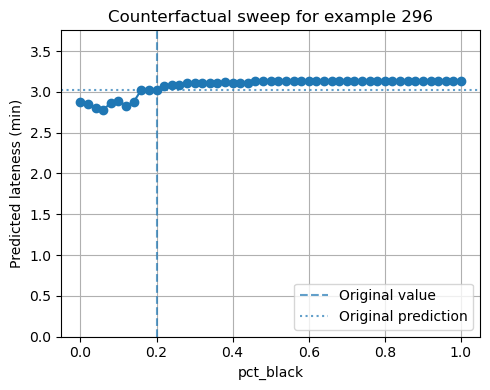

In [24]:
# Pick a few representative rows from test set
feature_to_vary = "pct_black"  # could also test pct_minority_stop
# values_grid = [0.0, 0.25, 0.5, 0.75, 1.0]
values_grid = np.linspace(0, 1, 51)  # 41 values: 0.00, 0.025, ..., 1.00


examples_idx = X_test.sample(5, random_state=0).index

for idx in examples_idx:
    row = X_test.loc[idx]
    base_pred = xgb_model.predict(pd.DataFrame([row]))[0]
    cf_preds = counterfactual_sweep(row, feature_to_vary, values_grid)

    # ==== PRINT RESULTS ====
    print(f"\nExample index: {idx}")
    print(f"  Original {feature_to_vary}: {row[feature_to_vary]:.2f}")
    print(f"  Original prediction: {base_pred:.3f} minutes")
    print("  Counterfactual predictions (varying pct_black share):")
    # for v, p in cf_preds.items():
    #     # print(f"    {feature_to_vary}={v:4.2f} → pred lateness={p:.3f} min")

    # ==== PLOT RESULTS ====
    vals = np.array(values_grid)
    preds_arr = np.array([cf_preds[v] for v in values_grid])

    plt.figure(figsize=(5, 4))
    plt.plot(vals, preds_arr, marker="o")
    # Mark the original point
    plt.axvline(row[feature_to_vary], linestyle="--", alpha=0.7, label="Original value")
    plt.axhline(base_pred, linestyle=":", alpha=0.7, label="Original prediction")

    plt.xlabel(feature_to_vary)
    plt.ylabel("Predicted lateness (min)")
    plt.title(f"Counterfactual sweep for example {idx}")
    plt.ylim(0, max(preds_arr.max(), base_pred) * 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### for pct_hispanic


Example index: 924
  Original pct_hispanic: 0.22
  Original prediction: 3.862 minutes
  Counterfactual predictions (varying pct_hispanic share):


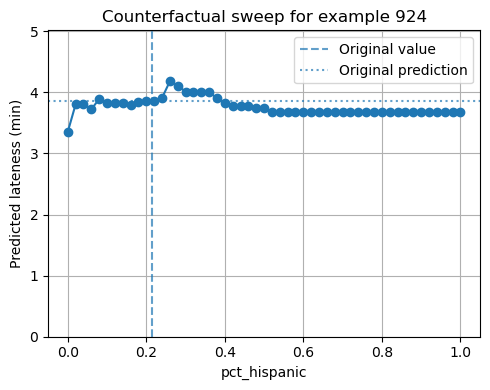


Example index: 981
  Original pct_hispanic: 0.21
  Original prediction: 2.939 minutes
  Counterfactual predictions (varying pct_hispanic share):


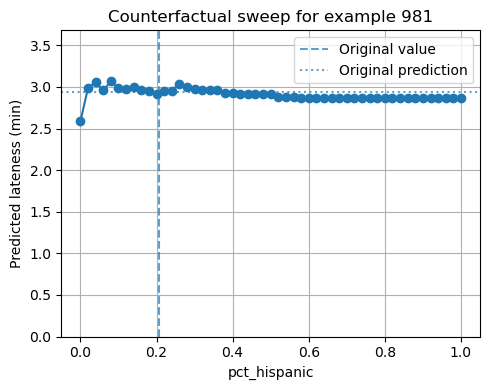


Example index: 809
  Original pct_hispanic: 0.10
  Original prediction: 5.046 minutes
  Counterfactual predictions (varying pct_hispanic share):


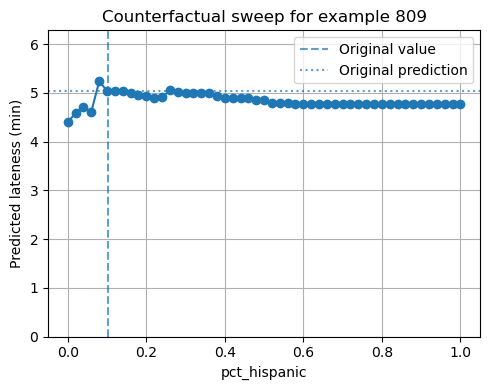


Example index: 589
  Original pct_hispanic: 0.21
  Original prediction: 3.591 minutes
  Counterfactual predictions (varying pct_hispanic share):


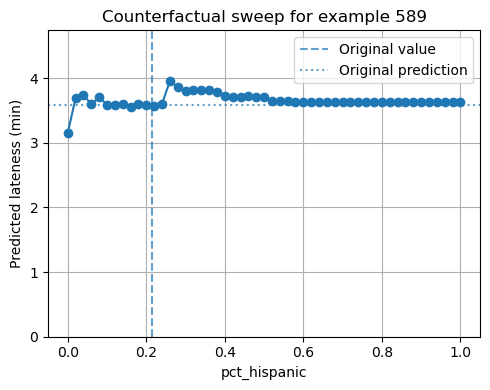


Example index: 296
  Original pct_hispanic: 0.13
  Original prediction: 3.020 minutes
  Counterfactual predictions (varying pct_hispanic share):


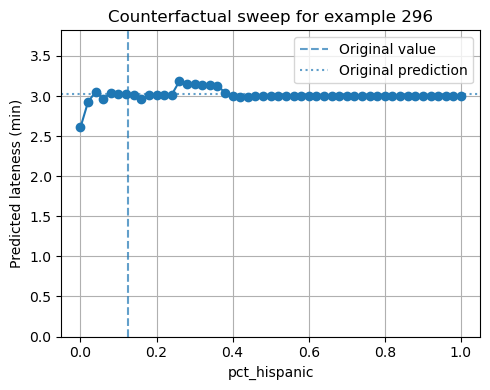

In [27]:
# Pick a few representative rows from test set
feature_to_vary = "pct_hispanic"  # could also test pct_minority_stop
# values_grid = [0.0, 0.25, 0.5, 0.75, 1.0]
values_grid = np.linspace(0, 1, 51)  # 41 values: 0.00, 0.025, ..., 1.00


examples_idx = X_test.sample(5, random_state=0).index

for idx in examples_idx:
    row = X_test.loc[idx]
    base_pred = xgb_model.predict(pd.DataFrame([row]))[0]
    cf_preds = counterfactual_sweep(row, feature_to_vary, values_grid)

    # ==== PRINT RESULTS ====
    print(f"\nExample index: {idx}")
    print(f"  Original {feature_to_vary}: {row[feature_to_vary]:.2f}")
    print(f"  Original prediction: {base_pred:.3f} minutes")
    print("  Counterfactual predictions (varying pct_hispanic share):")
    # for v, p in cf_preds.items():
    #     # print(f"    {feature_to_vary}={v:4.2f} → pred lateness={p:.3f} min")

    # ==== PLOT RESULTS ====
    vals = np.array(values_grid)
    preds_arr = np.array([cf_preds[v] for v in values_grid])

    plt.figure(figsize=(5, 4))
    plt.plot(vals, preds_arr, marker="o")
    # Mark the original point
    plt.axvline(row[feature_to_vary], linestyle="--", alpha=0.7, label="Original value")
    plt.axhline(base_pred, linestyle=":", alpha=0.7, label="Original prediction")

    plt.xlabel(feature_to_vary)
    plt.ylabel("Predicted lateness (min)")
    plt.title(f"Counterfactual sweep for example {idx}")
    plt.ylim(0, max(preds_arr.max(), base_pred) * 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### for pct_asian


Example index: 924
  Original pct_asian: 0.20
  Original prediction: 3.862 minutes
  Counterfactual predictions (varying pct_asian share):


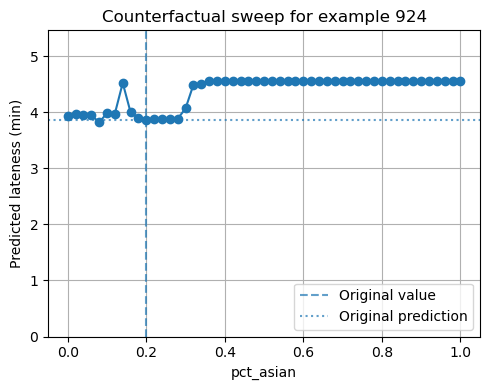


Example index: 981
  Original pct_asian: 0.26
  Original prediction: 2.939 minutes
  Counterfactual predictions (varying pct_asian share):


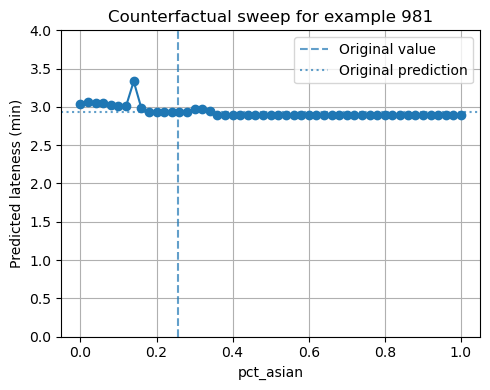


Example index: 809
  Original pct_asian: 0.16
  Original prediction: 5.046 minutes
  Counterfactual predictions (varying pct_asian share):


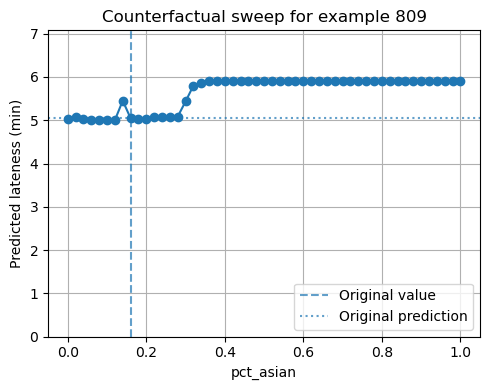


Example index: 589
  Original pct_asian: 0.04
  Original prediction: 3.591 minutes
  Counterfactual predictions (varying pct_asian share):


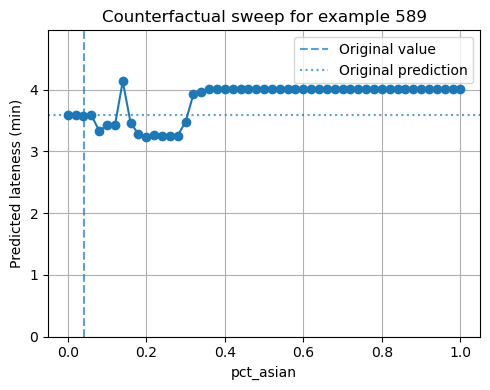


Example index: 296
  Original pct_asian: 0.12
  Original prediction: 3.020 minutes
  Counterfactual predictions (varying pct_asian share):


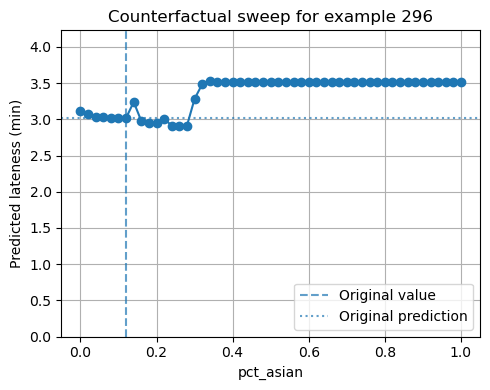

In [25]:
# Pick a few representative rows from test set
feature_to_vary = "pct_asian"  # could also test pct_minority_stop
# values_grid = [0.0, 0.25, 0.5, 0.75, 1.0]
values_grid = np.linspace(0, 1, 51)  # 41 values: 0.00, 0.025, ..., 1.00


examples_idx = X_test.sample(5, random_state=0).index

for idx in examples_idx:
    row = X_test.loc[idx]
    base_pred = xgb_model.predict(pd.DataFrame([row]))[0]
    cf_preds = counterfactual_sweep(row, feature_to_vary, values_grid)

    # ==== PRINT RESULTS ====
    print(f"\nExample index: {idx}")
    print(f"  Original {feature_to_vary}: {row[feature_to_vary]:.2f}")
    print(f"  Original prediction: {base_pred:.3f} minutes")
    print("  Counterfactual predictions (varying pct_asian share):")
    # for v, p in cf_preds.items():
    #     # print(f"    {feature_to_vary}={v:4.2f} → pred lateness={p:.3f} min")

    # ==== PLOT RESULTS ====
    vals = np.array(values_grid)
    preds_arr = np.array([cf_preds[v] for v in values_grid])

    plt.figure(figsize=(5, 4))
    plt.plot(vals, preds_arr, marker="o")
    # Mark the original point
    plt.axvline(row[feature_to_vary], linestyle="--", alpha=0.7, label="Original value")
    plt.axhline(base_pred, linestyle=":", alpha=0.7, label="Original prediction")

    plt.xlabel(feature_to_vary)
    plt.ylabel("Predicted lateness (min)")
    plt.title(f"Counterfactual sweep for example {idx}")
    plt.ylim(0, max(preds_arr.max(), base_pred) * 1.2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
